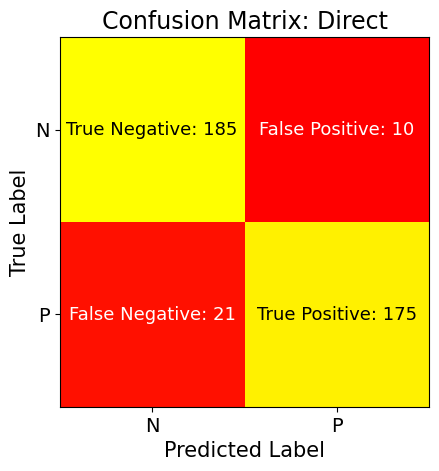

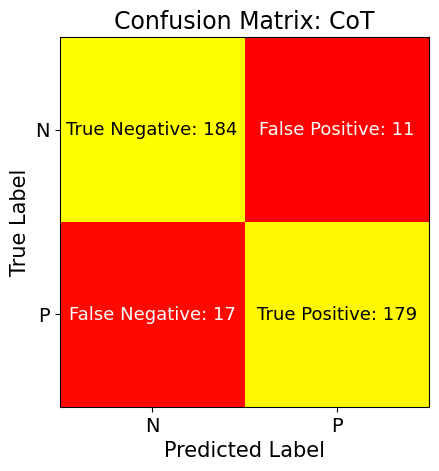

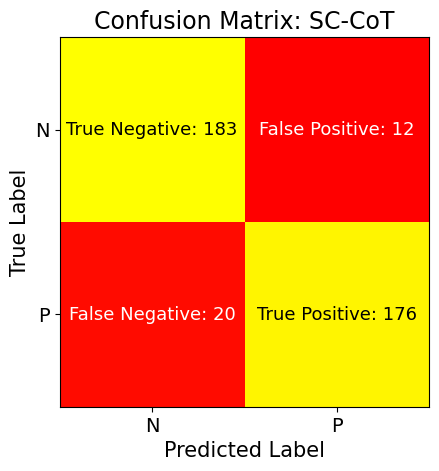

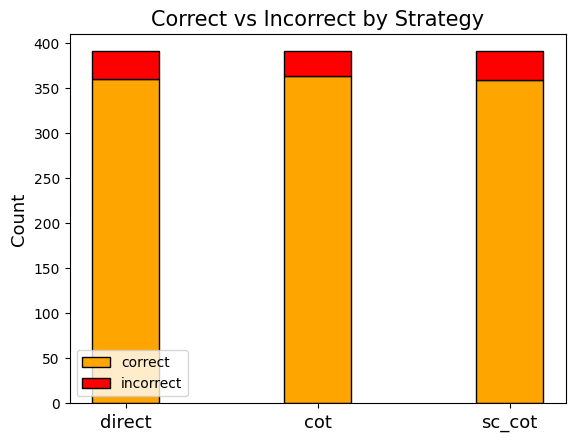

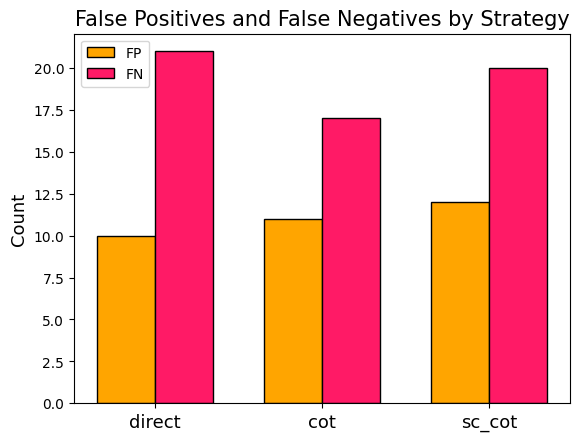

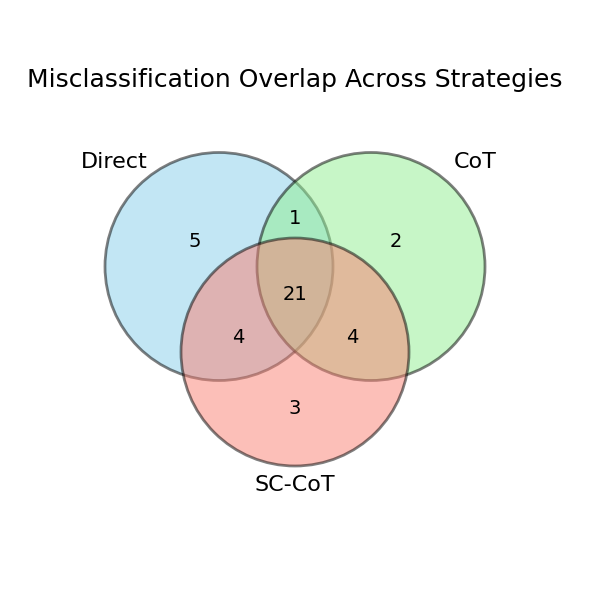

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from statsmodels.stats.contingency_tables import mcnemar
filepath = "/content/drive/MyDrive/Colab Notebooks/School work/CS 159/summary GPT o4-mini.csv"
# Load data
df = pd.read_csv(filepath)
strategy_counts = df.groupby('snippet_id')['strategy'].nunique()

# Keep only snippet_ids present in all 3 strategies
valid_ids = strategy_counts[strategy_counts == 3].index

# Filter the DataFrame to those valid snippet_ids
df = df[df['snippet_id'].isin(valid_ids)].reset_index(drop=True)
df["mis"] = df["true_label"] != df["pred_label"]

# Pivot to wide form: index=snippet_id, columns=strategy, values=0/1 misflag
mis = (df.pivot(index="snippet_id",
                columns="strategy",
                values="mis")
         .astype(int))




# 1. Confusion matrices per strategy
strategies = ['direct', 'cot', 'sc_cot']
label = ["Direct", "CoT", "SC-CoT"]
figures = {}
for i, strat in enumerate(strategies):
    sub = df[df['strategy'] == strat]
    cm = confusion_matrix(sub['true_label'], sub['pred_label'])

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap="autumn")
    plt.title(f'Confusion Matrix: {label[i]}', fontsize=17)
    plt.xticks([0, 1], ['N', 'P'], fontsize=14)
    plt.yticks([0, 1], ['N', 'P'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=15)
    plt.ylabel('True Label', fontsize=15)

    # Annotate matrix cells
    for (i, j), val in np.ndenumerate(cm):
        match i, j:
            case 0, 0:
                txt = f'True Negative: {val}'
                plt.text(j, i, txt, ha='center', va='center', color='black', fontsize=13)
            case 1, 1:
                txt = f'True Positive: {val}'
                plt.text(j, i, txt, ha='center', va='center', color='black', fontsize=13)
            case 1, 0:
                txt = f'False Negative: {val}'
                plt.text(j, i, txt, ha='center', va='center', color='white', fontsize=13)
            case 0, 1:
                txt = f'False Positive: {val}'
                plt.text(j, i, txt, ha='center', va='center', color='white', fontsize=13)

    plt.show()

# 2. Stacked Bar chart of accuracies
width = 0.35
counts = {}
for strat in strategies:
    sub = df[df.strategy == strat]
    correct = (sub.true_label == sub.pred_label).sum()
    total = len(sub)
    incorrect = total - correct
    counts[strat] = {'correct': correct, 'incorrect': incorrect}

fig, ax = plt.subplots()
x = np.arange(len(strategies))
corrects = [counts[s]['correct'] for s in strategies]
incorrects = [counts[s]['incorrect'] for s in strategies]
ax.bar(x, corrects, width, label='correct', color='orange', edgecolor="k")
ax.bar(x, incorrects, width, bottom=corrects, label='incorrect', color='red', edgecolor="k")
ax.set_xticks(x)
ax.set_xticklabels(strategies, fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.set_title('Correct vs Incorrect by Strategy', fontsize=15)
ax.legend()
plt.show()

# 3. Grouped bar: False Positives vs False Negatives
fp = []
fn = []
for strat in strategies:
    sub = df[df.strategy == strat]
    cm = confusion_matrix(sub.true_label, sub.pred_label)
    tn, fp_count, fn_count, tp = cm.ravel()
    fp.append(fp_count)
    fn.append(fn_count)

fig, ax = plt.subplots()
x = np.arange(len(strategies))
ax.bar(x - width/2, fp, width, label='FP', color='orange', edgecolor="k")
ax.bar(x + width/2, fn, width, label='FN', color=(1,0.1,0.4), edgecolor="k")
ax.set_xticks(x)
ax.set_xticklabels(strategies, fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.set_title('False Positives and False Negatives by Strategy', fontsize=15)
ax.legend()
plt.show()

from matplotlib_venn import venn3, venn3_circles
from matplotlib.patches import Circle
from collections import Counter

# Rename columns to match your display keys
mis = mis.rename(columns={
    "direct": "Direct",
    "cot":    "CoT",
    "sc_cot": "SC-CoT",
})

# Build a 3-bit string per snippet in the order [Direct, CoT, SC-CoT]
bitstr = mis[["Direct","CoT","SC-CoT"]].astype(str).agg("".join, axis=1)

# Count occurrences of each pattern
counts = Counter(bitstr)
# Ensure all 7 areas are present (even if zero)
for key in ["100","010","001","110","101","011","111"]:
    counts.setdefault(key, 0)

# Now counts is exactly what you need:
#   counts["100"] = # misclassified by Direct only
#   counts["110"] = # misclassified by Direct & CoT only
#   … etc.

# ───────────────────────────────────────────────────────────────────────────────
# 1) Draw your Venn‐style circles & annotate with counts
# ───────────────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(6,6))

# Circle geometry (unchanged)
coords = {'Direct': (-1.90, 1.40), 'CoT': (1.90, 1.40), 'SC-CoT': (0, -2.0)}
centers = {'Direct': (-0.8, 0.3), 'CoT': (0.8, 0.3), 'SC-CoT': (0, -0.6)}
radius = 1.2
colors = {'Direct': 'skyblue', 'CoT': 'lightgreen', 'SC-CoT': 'salmon'}

for name, center in centers.items():
    circ = Circle(center, radius=radius, alpha=0.5, linewidth=2,
                  edgecolor='black', facecolor=colors[name])
    ax.add_patch(circ)

# Label positions (unchanged)
label_coords = {
    '100': (-1.06, 0.56),
    '010': (1.06, 0.56),
    '001': (0, -1.2),
    '110': (0, 0.8),
    '101': (-0.6, -0.45),
    '011': (0.6, -0.45),
    '111': (0, 0)
}

# Place the dynamic counts
for key, count in counts.items():
    if key == "000":
        continue
    x, y = label_coords[key]
    ax.text(x, y, str(count), ha='center', va='center', fontsize=14)

# Place the set labels
for name, (x,y) in coords.items():
    ax.text(x, y, name, ha='center', va='center', fontsize=16)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.axis('off')
ax.set_title(
    'Misclassification Overlap Across Strategies',
    fontsize=18,
    y=0.85
)
plt.tight_layout()
plt.show()

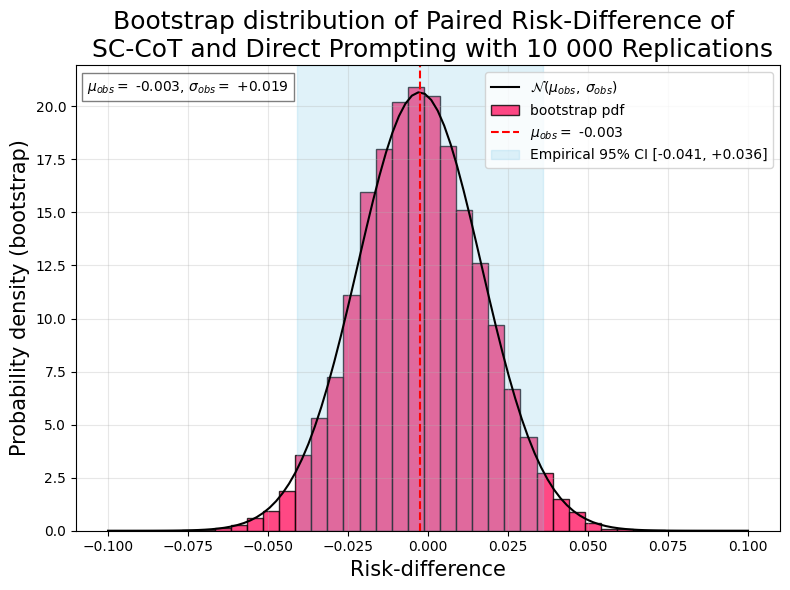

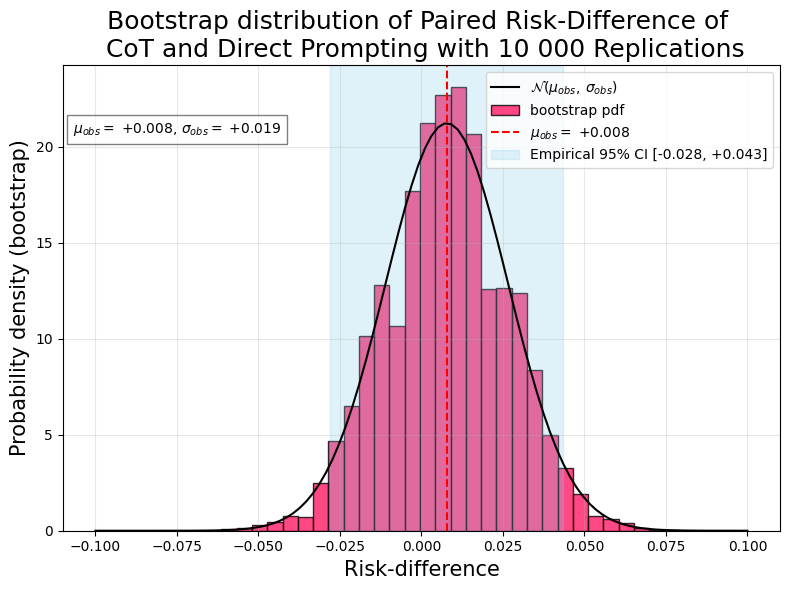

In [ ]:
truth = df.drop_duplicates("snippet_id").set_index("snippet_id")["true_label"]

# correctness matrix (shape 50 × 3, values 0/1)
mat = (df.pivot(index="snippet_id",
                columns="strategy",
                values="pred_label")
         .eq(truth, axis=0).astype(int))

# choose the two strategies you want to compare
A, B, C = "direct", "sc_cot", "cot"      # change 'sc_cot' → 'cot' if desired

# ───────────────────────────────────────────────────────────────────────────────
# 2) Risk-difference and Newcombe 95 % CI (pure Python)
# ───────────────────────────────────────────────────────────────────────────────
from scipy.stats import norm
import math
Z = norm.ppf(0.975)          # 1.96

def wilson_ci(k, n, z=Z):
    if n == 0: return (0,1)
    p = k / n
    denom  = 1 + z**2/n
    centre = (p + z**2/(2*n)) / denom
    half   = z*math.sqrt((p*(1-p) + z**2/(4*n))/n) / denom
    return centre - half, centre + half

def newcombe_ci(k1,n1,k2,n2,z=Z):
    lo1, hi1 = wilson_ci(k1,n1,z)
    lo2, hi2 = wilson_ci(k2,n2,z)
    return lo2 - hi1, hi2 - lo1

n       = len(mat)
a_corr  = mat[A];   b_corr  = mat[B]; c_corr  = mat[C]

ci_lo, ci_hi = newcombe_ci(b_corr.sum(), n, a_corr.sum(), n)

# ───────────────────────────────────────────────────────────────────────────────
# 3) Exact McNemar p-value
# ───────────────────────────────────────────────────────────────────────────────
x01 = int(((a_corr==0)&(b_corr==1)).sum())   # A wrong, B right
x10 = int(((a_corr==1)&(b_corr==0)).sum())   # A right, B wrong
b = x01 + x10
p_mcnemar = (1.0 if b==0 else
             2*sum(math.comb(b,i)*0.5**b for i in range(0, min(x01,x10)+1)))

# ───────────────────────────────────────────────────────────────────────────────
# 4) Bootstrap distribution of risk-difference (10 000 resamples)
# ───────────────────────────────────────────────────────────────────────────────
# --- Bootstrap sampling -------------------------------------------------------
rng = np.random.default_rng(0)
boots = [
    b_corr.iloc[rng.integers(0, n, n)].mean()
  - a_corr.iloc[rng.integers(0, n, n)].mean()
    for _ in range(10_000)
]

# --- 95 % empirical CI --------------------------------------------------------
ci_lo, ci_hi = np.percentile(boots, [2.5, 97.5])

# --- Plot ---------------------------------------------------------------------
plt.figure(figsize=(8,6))
[mu, sig] = (np.mean(boots), np.std(boots))
x = np.linspace(-0.1,
                0.1, 100)
y = norm.pdf(x, mu, sig)

plt.plot(x, norm.pdf(x, mu, sig),
       'k', alpha=1, label='$\mathcal{N}(\mu_{obs}, \: \sigma_{obs})$')
plt.hist(boots, bins=30, density=True, color=(1,0.1,0.4),
         edgecolor="k", alpha=0.8, label="bootstrap pdf")

# observed diff
txt = rf"$\mu_{{obs}} = $ {mu:+.3f}"
plt.axvline(mu, ls="--", color="red", label=txt)
txt += f", $\sigma_{{obs}} = $ {sig:+.3f}"
# 95 % CI band
plt.axvspan(ci_lo, ci_hi, color="skyblue", alpha=0.25,
            label=f"Empirical 95% CI [{ci_lo:+.3f}, {ci_hi:+.3f}]")

plt.xlabel("Risk-difference", fontsize=15)
plt.ylabel("Probability density (bootstrap)", fontsize=15)
plt.title("Bootstrap distribution of Paired Risk-Difference of \n SC-CoT and Direct Prompting with 10 000 Replications", fontsize=18)
plt.text(-0.075, 20.9, txt, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



boots_2 = [
    c_corr.iloc[rng.integers(0, n, n)].mean()
  - a_corr.iloc[rng.integers(0, n, n)].mean()
    for _ in range(10_000)
]

# --- 95 % empirical CI --------------------------------------------------------
ci_lo, ci_hi = np.percentile(boots_2, [2.5, 97.5])

# --- Plot ---------------------------------------------------------------------
plt.figure(figsize=(8,6))
[mu, sig] = (np.mean(boots_2), np.std(boots_2))
x = np.linspace(-0.1,
                0.1, 100)
y = norm.pdf(x, mu, sig)

plt.plot(x, norm.pdf(x, mu, sig),
       'k', alpha=1, label='$\mathcal{N}(\mu_{obs}, \: \sigma_{obs})$')
plt.hist(boots_2, bins=30, density=True, color=(1,0.1,0.4),
         edgecolor="k", alpha=0.8, label="bootstrap pdf")

# observed diff
txt = rf"$\mu_{{obs}} = $ {mu:+.3f}"
plt.axvline(mu, ls="--", color="red", label=txt)
txt += f", $\sigma_{{obs}} = $ {sig:+.3f}"
# 95 % CI band
plt.axvspan(ci_lo, ci_hi, color="skyblue", alpha=0.25,
            label=f"Empirical 95% CI [{ci_lo:+.3f}, {ci_hi:+.3f}]")

plt.xlabel("Risk-difference", fontsize=15)
plt.ylabel("Probability density (bootstrap)", fontsize=15)
plt.title("Bootstrap distribution of Paired Risk-Difference of \n CoT and Direct Prompting with 10 000 Replications", fontsize=18)
plt.text(-0.075, 20.9, txt, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df = pd.read_csv(filepath)
z = norm.ppf(0.975)

sc = df[df["strategy"] == "sc_cot"]
cot = df[df["strategy"] == "cot"]
direct = df[df["strategy"] == "direct"]
sc_correct = (sc["true_label"] == sc["pred_label"]).sum()
cot_correct = (cot["true_label"] == cot["pred_label"]).sum()
direct_correct = (direct["true_label"] == direct["pred_label"]).sum()
sc_total = len(sc)
cot_total = len(cot)
direct_total = len(direct)
total = 400

print(f"SC-CoT correct: {sc_correct}")
print(f"SC-CoT total: {sc_total}")
print(f"SC-CoT accuracy: {sc_correct/total}")
print(f"CoT correct: {cot_correct}")
print(f"CoT total: {cot_total}")
print(f"CoT accuracy: {cot_correct/total}")
print(f"Direct correct: {direct_correct}")
print(f"Direct total: {direct_total}")
print(f"Direct accuracy: {direct_correct/total}")

SC_CI = wilson_ci(sc_correct, total, z)
CoT_CI = wilson_ci(cot_correct, total, z)
Direct_CI = wilson_ci(direct_correct, total, z)

print(f"SC-CoT 95% CI: {SC_CI}")
print(f"CoT 95% CI: {CoT_CI}")
print(f"Direct 95% CI: {Direct_CI}")

SC-CoT correct: 359
SC-CoT total: 393
SC-CoT accuracy: 0.8975
CoT correct: 367
CoT total: 398
CoT accuracy: 0.9175
Direct correct: 363
Direct total: 399
Direct accuracy: 0.9075
SC-CoT 95% CI: (np.float64(0.8638965789864277), np.float64(0.9235411470178065))
CoT 95% CI: (np.float64(0.8864031104605777), np.float64(0.9406541237702847))
Direct 95% CI: (np.float64(0.8751014146161221), np.float64(0.9321460655014261))


In [24]:
filepath = "/content/drive/MyDrive/Colab Notebooks/School work/CS 159/summary GPT o4-mini uniform temp.csv"
df = pd.read_csv(filepath)
strategy_counts = df.groupby('snippet_id')['strategy'].nunique()

# Keep only snippet_ids present in all 3 strategies
valid_ids = strategy_counts[strategy_counts == 3].index

# Filter the DataFrame to those valid snippet_ids
df = df[df['snippet_id'].isin(valid_ids)].reset_index(drop=True)
df["mis"] = df["true_label"] != df["pred_label"]

z = norm.ppf(0.975)

sc = df[df["strategy"] == "sc_cot"]
cot = df[df["strategy"] == "cot"]
direct = df[df["strategy"] == "direct"]
sc_correct = (sc["true_label"] == sc["pred_label"]).sum()
cot_correct = (cot["true_label"] == cot["pred_label"]).sum()
direct_correct = (direct["true_label"] == direct["pred_label"]).sum()
sc_total = len(sc)
cot_total = len(cot)
direct_total = len(direct)
total = 400
print("Fixed Temperature of 0.7: \n")
print(f'Number of snippets not classified by all three strategies: {total - sc_total}')
print(f"SC-CoT correct: {sc_correct}")
print(f"SC-CoT total: {sc_total}")
print(f"SC-CoT accuracy: {sc_correct/total}")
print(f"CoT correct: {cot_correct}")
print(f"CoT total: {cot_total}")
print(f"CoT accuracy: {cot_correct/total}")
print(f"Direct correct: {direct_correct}")
print(f"Direct total: {direct_total}")
print(f"Direct accuracy: {direct_correct/total}")

SC_CI = wilson_ci(sc_correct, total, z)
CoT_CI = wilson_ci(cot_correct, total, z)
Direct_CI = wilson_ci(direct_correct, total, z)

print(f"SC-CoT 95% CI: {SC_CI}")
print(f"CoT 95% CI: {CoT_CI}")
print(f"Direct 95% CI: {Direct_CI}")

Fixed Temperature of 0.7: 

Number of snippets not classified by all three strategies: 173
SC-CoT correct: 225
SC-CoT total: 227
SC-CoT accuracy: 0.5625
CoT correct: 222
CoT total: 227
CoT accuracy: 0.555
Direct correct: 224
Direct total: 227
Direct accuracy: 0.56
SC-CoT 95% CI: (np.float64(0.5135188136473868), np.float64(0.6102921495608261))
CoT 95% CI: (np.float64(0.506004433664882), np.float64(0.6029492139583456))
Direct 95% CI: (np.float64(0.5110127871951399), np.float64(0.6078457374847447))
